In [1]:
import json
from os import listdir
from os.path import join
import pandas as pd
import networkx as nx

from typing import List

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_json_dir (directory: str) -> List[dict]: 
    '''
    Load each file in a directory of JSON files
    '''
    filenames = listdir(directory)
    def load_by_fn (fn: str) -> dict:
        return json.load(open(join(directory, fn)))
    return [load_by_fn(f) for f in filenames if f != 'search.json']

# By country

In [3]:
countries = load_json_dir('www.submarinecablemap.com/public/api/v2/country/')

## Placename to cc

In [4]:
cc_codes = pd.read_csv('country_to_cc.csv')

def country_to_cc2 (country_name: str) -> str:
    try:
        return cc_codes[cc_codes['Country']==country_name]['Alpha-2 code'].values[0].split('"')[1]
    except:
        raise Exception(f'Cannot find {country_name}')

In [5]:
def cc_to_country (cc2: str) -> str:
    return cc_codes[cc_codes['Alpha-2 code']==f' "{cc2}"']['Country'].values[0]

cc_to_country('US')

'United States'

In [6]:
def place_name_to_cc2 (placename: str) -> str:
    try:
        count_name = placename.split(',')[-1].strip()
        return country_to_cc2(count_name)
    except:
        # sometimes country names have a comma (e.g., 'Congo, Dem. Rep.')
        count_name = placename.split(',')[-2].strip()
        return country_to_cc2(count_name)
# [place_name_to_cc2(n) for n in place_names]

## Parse RFS date

In [7]:
cables = load_json_dir('www.submarinecablemap.com/public/api/v2/cable/')

In [8]:
def get_cable (cable_id):
    for cable in cables:
        try:
            if cable['cable_id'] == cable_id:
                return cable
        except:
            pass
    raise Exception(f'Cannot find cable with id {cable_id}')
    
c = get_cable(1891)
c

{'id': 'labuan-brunei-submarine-cable',
 'name': 'Labuan-Brunei Submarine Cable',
 'cable_id': 1891,
 'landing_points': [{'landing_point_id': 16695,
   'id': 'kiamsam-malaysia',
   'name': 'Kiamsam, Malaysia',
   'latlon': '5.255329,115.168938',
   'url': '#/landing-point/kiamsam-malaysia',
   'is_tbd': 'false'},
  {'landing_point_id': 5970,
   'id': 'tungku-brunei',
   'name': 'Tungku, Brunei',
   'latlon': '4.926371,114.885833',
   'url': '#/landing-point/tungku-brunei',
   'is_tbd': 'false'}],
 'length': '52 km',
 'rfs': '2017 April',
 'owners': 'Common Tower Technologies Sdn Bhd',
 'url': 'http://www.cttsb.com.my',
 'notes': None}

In [9]:
from datetime import datetime

def parse_rfs_date (cable: dict) -> datetime:
    try:
        rfs = cable['rfs']
    except:
        raise Exception('No RFS date found for cable.')
    try:
        parsed = datetime.strptime(rfs, '%Y')
        return parsed
    except:
        try:
            parsed = datetime.strptime(rfs, '%Y %B')
            return parsed
        except:
            try:
                y, q = rfs.split(' ')
                y = int(y)
                if q == 'Q1':
                    parsed = datetime(y, 1, 1)
                elif q == 'Q2':
                    parsed = datetime(y, 4, 1)
                elif q == 'Q3':
                    parsed = datetime(y, 7, 1)
                elif q == 'Q4':
                    parsed = datetime(y, 10, 1)
                return parsed
            except:
                raise Exception('Cannot parse RFS for cable.')

In [10]:
def is_ready_for_service (cable):
    '''
    See if a cable is ready for service. If we can't parse the date, assume it isn't.
    '''
    try:
        return parse_rfs_date(cable) < datetime.now()
    except:
        return False

is_ready_for_service(get_cable(2144))

True

# Make a graph for the whole world

In [11]:
def get_connections (country_or_cable):
    landings = country_or_cable['landing_points']
    names = [l['name'] for l in landings]
    return names

place_names = get_connections(countries[5])
# place_names

In [12]:
def construct_graph (include_future_cables=False):
    G = nx.Graph()
    for country in countries:
        cc2 = country_to_cc2(country['name'])
        # add nodes for each country
        G.add_node(cc2)
    for country in countries:
        # add edges for each country
        from_cc2 = country_to_cc2(country['name'])
        cables = [get_cable(c['cable_id']) 
                  for c in country['cables']]
        # if we are choosing to exclude future cables
        if not include_future_cables:
            # only include cables ready for service today
            cables = [c for c in cables if is_ready_for_service(c)]
        for cable in cables:
            connection_names = get_connections(cable)
            connection_cc2s = [place_name_to_cc2(n) for n in connection_names]
            for to_cc2 in connection_cc2s:
                # take international connections only
                if from_cc2 != to_cc2:
                    G.add_edge(from_cc2, to_cc2)
    return G

G = construct_graph()

In [13]:
future_G = construct_graph(include_future_cables=True)

# Analyze the graph of the world

https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python#the-shape-of-the-network

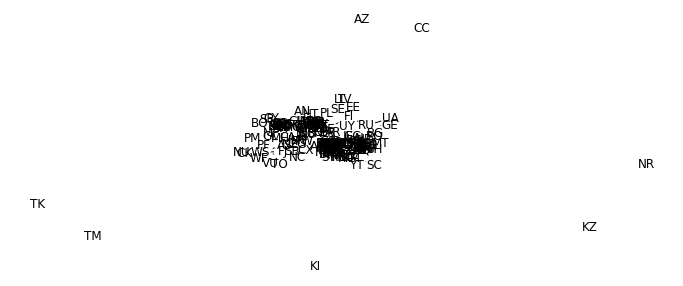

In [14]:
def plot_net (graph):
    color_map = []
    for node in graph:
        if node == 'US':
            color_map.append('red')
        else: 
            color_map.append('white')      
            
    fig, ax = plt.subplots(1, 1, figsize=(12, 5));
    nx.draw(graph, node_color=color_map, with_labels=True)
    plt.show()
    
plot_net(G) 

# Network density

In [15]:
density = nx.density(G)
density

0.08593046297964331

## Diameter (of largest subgraph)

In [16]:
# Next, use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(G)
largest_component = max(components, key=len)

# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph, just like you did with density.
#

subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
diameter

6

# Plot of largest subgraph

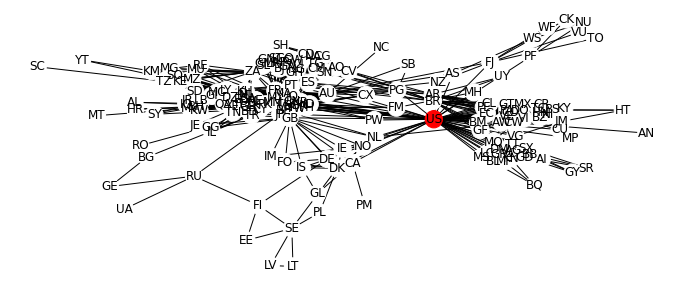

In [17]:
plot_net(subgraph)

## Clustering coefficient
Transitivity is the ratio of all triangles over all possible triangles. A possible triangle exists when one person (Fox) knows two people (Fell and Whitehead). So transitivity, like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections. 

In [18]:
nx.transitivity(G)

0.6449569053970859

## Degree centrality

In [19]:
from operator import itemgetter

In [20]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [21]:
def top_n (my_dict, n, reverse=True):
    sorted_dict = sorted(my_dict.items(), key=itemgetter(1), reverse=reverse)
    return sorted_dict[:n]

In [22]:
top_degree = top_n(degree_dict, 20)

<AxesSubplot:>

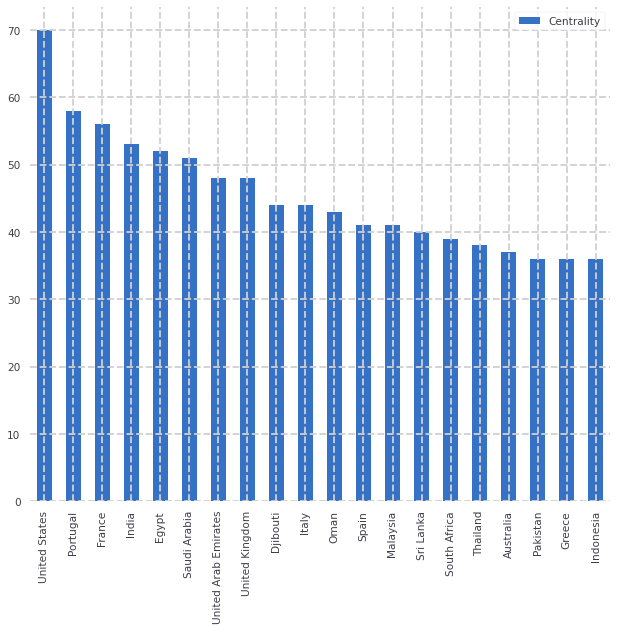

In [41]:
def plot_top (top_lst, title='Centrality', **kwargs):
    degree = pd.DataFrame(top_lst, columns=['Country', title])
    degree.index = degree['Country']
    degree['Country'] = degree['Country'].apply(cc_to_country)
    ax = degree.plot.bar(**kwargs)
    ax.set_xlabel('')
    return ax
    
plot_top(top_degree)

## Betweeness centrality

In [24]:
from jupyterthemes import jtplot

# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1, spines=False, gridlines='--')

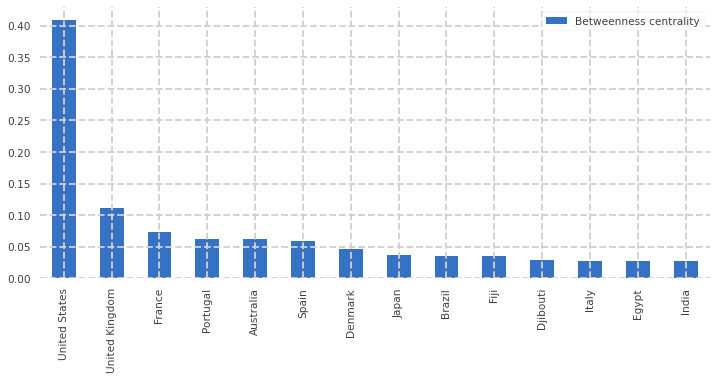

In [47]:
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
ax = plot_top(top_n(betweenness_dict, 14), title='Betweenness centrality', figsize=(12, 5))

In [26]:
top_n(betweenness_dict, 1)

[('US', 0.40958780793642824)]

#### Compare to future graph!
will US's power increase/decrease in the future?

In [27]:
future_betweenness_dict = nx.betweenness_centrality(future_G) # Run betweenness centrality
nx.set_node_attributes(future_G, future_betweenness_dict, 'betweenness')
top_n(future_betweenness_dict, 1)

[('US', 0.42827698973195827)]

In [28]:
def change_in_future (cc2):
    return (future_betweenness_dict[cc2] - betweenness_dict[cc2])/ betweenness_dict[cc2]

In [29]:
change_in_future('US')

0.045629243433024165

In [30]:
change_in_future('CN')

-0.15233532578617476

## Eigenvector centrality

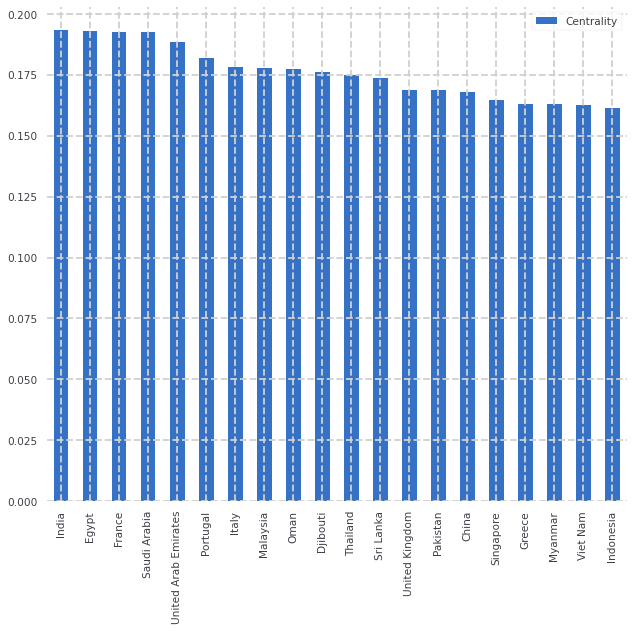

In [31]:
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')
plot_top(top_n(eigenvector_dict, 20))

## Community detection

In [32]:
import community

In [33]:
communities = community.best_partition(G)
nx.set_node_attributes(G, communities, 'modularity')

In [34]:
G.nodes['US']

{'degree': 70,
 'betweenness': 0.40958780793642824,
 'eigenvector': 0.08450398863284823,
 'modularity': 6}

In [35]:
def eigenvector_in_class (class_n, top=3):
    # First get a list of just the nodes in that class
    class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == class_n]
    # Then create a dictionary of the eigenvector centralities of those nodes
    class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0}
    # Then sort that dictionary and print the first 5 results
    class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)
    return class0_sorted_by_eigenvector[:top]

eigenvector_in_class(4)

[('TM', 1.260044883752411e-30)]

In [36]:
communities_dict = {}
for node, group in communities.items():
    if group not in communities_dict:
        communities_dict[group] = [ node ]
    if group in communities_dict:
        member_lst = communities_dict[group]
        member_lst.append(node)
        communities_dict[group] = member_lst
communities_dict

{0: ['AZ', 'AZ'],
 10: ['PM',
  'PM',
  'NO',
  'BG',
  'IE',
  'CA',
  'EE',
  'IS',
  'RU',
  'DK',
  'GE',
  'RO',
  'IM',
  'GL',
  'DE',
  'NL',
  'SE',
  'FI',
  'UA',
  'FO',
  'LV',
  'PL',
  'LT'],
 2: ['MF',
  'MF',
  'VC',
  'BB',
  'BQ',
  'AI',
  'GD',
  'TT',
  'MQ',
  'MS',
  'AG',
  'DM',
  'SX',
  'VG',
  'BL',
  'KN',
  'GP',
  'LC',
  'GY',
  'SR'],
 3: ['MG', 'MG', 'SC', 'YT', 'TZ', 'SO', 'SD', 'MU', 'MZ', 'RE', 'KM', 'KE'],
 4: ['TM', 'TM'],
 5: ['BN',
  'BN',
  'GI',
  'MM',
  'IL',
  'DZ',
  'KR',
  'FR',
  'HR',
  'SA',
  'SG',
  'JE',
  'QA',
  'VN',
  'AE',
  'TN',
  'KH',
  'MA',
  'SY',
  'OM',
  'AL',
  'BE',
  'PK',
  'GG',
  'DJ',
  'PG',
  'JO',
  'BD',
  'CY',
  'GR',
  'CX',
  'TW',
  'PH',
  'ID',
  'NC',
  'JP',
  'YE',
  'IT',
  'BH',
  'LK',
  'IN',
  'GB',
  'EG',
  'LY',
  'KW',
  'IQ',
  'MY',
  'MV',
  'IR',
  'SB',
  'CN',
  'LB',
  'MC',
  'TR',
  'TH',
  'AU',
  'MT'],
 6: ['GF',
  'GF',
  'CW',
  'BR',
  'DO',
  'MH',
  'VE',
  'BZ',
  'CO'

# Who is most vulnerable to cable cutting?

## Who is only connected to one other node?

In [37]:
lowest_degree = top_n(degree_dict, 30, reverse=False)
for cc2, degree in lowest_degree:
    if degree==1:
        from_country = cc_to_country(cc2)
        edges = G.edges(cc2)
        for edge in edges:
            print(from_country, 'only connects to', cc_to_country(edge[1]))

Saint Pierre and Miquelon only connects to Canada
Seychelles only connects to Tanzania, United Republic of
Tonga only connects to Fiji
New Caledonia only connects to Australia
Northern Mariana Islands only connects to United States
Vanuatu only connects to Fiji
Netherlands Antilles only connects to Curacao
Ukraine only connects to Russian Federation
Malta only connects to Italy


In [38]:
betweenness_dict.values()

dict_values([0.0, 0.0, 0.003417484909197599, 0.00040272802703741927, 0.0, 0.006925934633043288, 0.0, 0.0, 0.0006747957010827281, 0.0006740736005211553, 0.0, 0.012929535669553661, 0.035783025313564316, 0.0, 7.358790886402088e-05, 0.005888737158914424, 0.00762657769101105, 0.07314132678960975, 0.0, 0.0032870235848090667, 0.0, 0.0041191043451388794, 0.0, 0.021542586676082602, 0.0, 0.013869881071773933, 0.0, 0.00013818169857701286, 0.001730812096925948, 0.009605060853859215, 0.014381230044234469, 0.0, 0.0, 0.006357786380922379, 0.0022379159908757383, 0.0, 0.0017892034263217154, 0.002242630705814467, 0.0, 0.018695943448054805, 0.0, 0.006357786380922379, 0.0, 0.0, 0.0048223001561957385, 0.00284936693939131, 0.0, 0.0, 0.012322795734416591, 0.0, 0.00219617468605472, 0.0017324094232734494, 0.0, 0.028620305249498008, 0.0019027606792823377, 0.0, 0.0, 0.00010832830537338378, 0.012892850345750812, 0.006974762155050149, 0.0, 0.010735970891414493, 0.0, 0.012586531345506151, 0.0035515275760539416, 9.8